# **Breast Cancer Detection - Predicting Invasive Ductal Carcinoma in Tissue Slices**

Runtime Terror Team

Alexis, Ashish, Taizhou, Zhiyu

## Background & Goal



### Motivation
Invasive ductal carcinoma (IDC) is - with ~ 80 % of cases - one of the most common types of breast cancer. It's malicious and able to form metastases which makes it especially dangerous. Often a biopsy is done to remove small tissue samples. Then a pathologist has to decide whether a patient has IDC, another type of breast cancer or is healthy. In addition sick cells need to be located to find out how advanced the disease is and which grade should be assigned. This has to be done manually and is a time consuming process. Furthermore the decision depends on the expertise of the pathologist and his or her equipment. Therefor deep learning could be of great help to automatically detect and locate tumor tissue cells and to speed up the process. In order to exploit the full potential one could build a pipeline using massive amounts of tissue image data of various hospitals that were evaluated by different experts. This way one would be able to overcome the dependence on the pathologist which would be especially useful in regions where no experts are available. 

### Our Goal
Our goal here is to develop a Deep Learning Model which can determine if the lump is cancerous or not without having to perform a biopsy or replying on the doctor's expertise.

### Background Info - What is Invasive Ductal Carcinoma?

<a title="Mikael Häggström, M.D. - Author info - Reusing images [CC BY (https://creativecommons.org/licenses/by/2.5)]" href="https://commons.wikimedia.org/wiki/File:Lobules_and_ducts_of_the_breast.jpg"><img width="309" alt="Lobules and ducts of the breast" style="float:left; margin:0px 15px 15px 15px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Lobules_and_ducts_of_the_breast.jpg/256px-Lobules_and_ducts_of_the_breast.jpg"></a>


This illustration created [Mikael Häggström](https://commons.wikimedia.org/wiki/File:Lobules_and_ducts_of_the_breast.jpg) shows the anatomy of a healthy breast. One can see the lobules, the glands that can produce milk which flews through the milk ducts. Ductal carcinoma starts to develop in the ducts whereas lobular carcinoma has its origin in the lobules. Invasive carcinoma is able to leave its initial tissue compartment and can form metastases.

## Imports & Reading Data

In [1]:
# All Imports 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image


from sklearn.model_selection import train_test_split

from glob import glob
from skimage.io import imread
from os import listdir

from tqdm import tqdm_notebook as tqdm

import os

import matplotlib.pylab as plt

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files

import keras_preprocessing.image as im

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import StandardScaler


import random




In [2]:
# Upload Kaggle JSON File with Credentials

upload = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [4]:
# Download Data as Zip File
!kaggle datasets download -d paultimothymooney/breast-histopathology-images 

100% 3.10G/3.10G [00:49<00:00, 23.2MB/s]



In [5]:
# Unzip Files
!unzip -o breast-histopathology-images.zip "IDC_regular_ps50_idx5/*/*.*" -d /content/breast-histopathology-images

Streaming output truncated to the last 5000 lines.
  inflating: /content/breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: /content/breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: /content/breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: /content/breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: /content/breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: /content/breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: /content/breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: /content/breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: /content/breast-

In [6]:
# Use glob() function to find the files recursively (It would be very difficult for any other way because the files are nested) 

DATA_PATH = "/content/breast-histopathology-images/IDC_regular_ps50_idx5"
files = listdir(DATA_PATH)

images = glob('/content/breast-histopathology-images/IDC_regular_ps50_idx5/**/*/*.png', recursive = True)

##Exploratory Analysis

###How many patients do we have?

In [7]:
folders = glob('/content/breast-histopathology-images/IDC_regular_ps50_idx5/*', recursive = True)
patient_id = []
for i in tqdm(folders):
  if(i[-5] == '/'):
    p = int(i[-4:])
    patient_id.append(p)
  else:
    p = int(i[-5:])
    patient_id.append(p)

print('Total Patients: ',len(patient_id))

  0%|          | 0/279 [00:00<?, ?it/s]

Total Patients:  279


We have 279 patients. Each patient has 2 folders '0' and '1' which are non-cancerous and cancerous respectively and each image is an Histopathology image of a single patch.

###How many patches do we have?

In [8]:
len(images)

277524

We have 277,524 total patches

###How many patches do we have per patient?

In [9]:
count_all = []
for i in patient_id:
  dir = glob('/content/breast-histopathology-images/IDC_regular_ps50_idx5/'+ str(i) +'/*/*', recursive = True)
  count_all.append(len(dir))

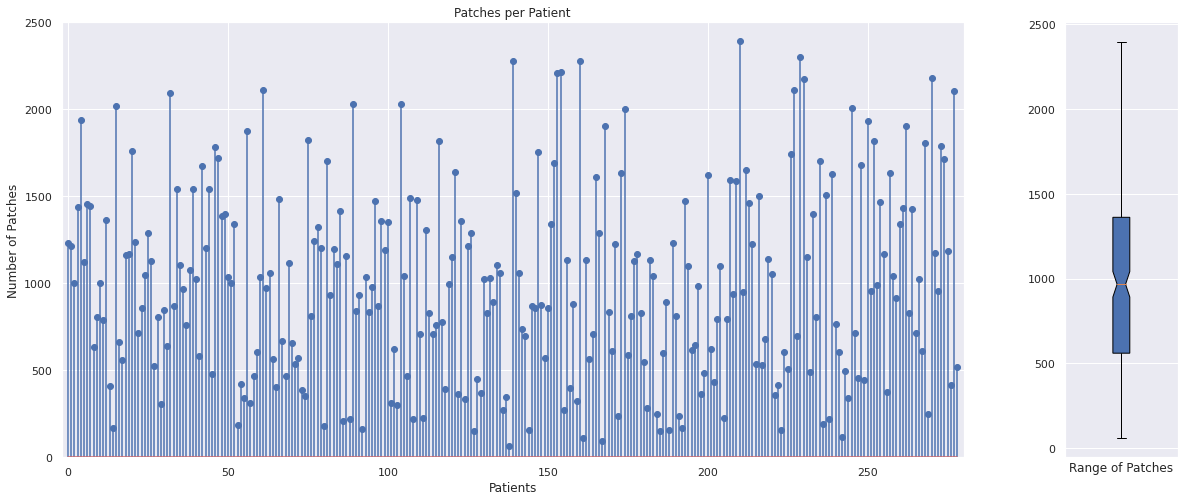

In [10]:
fig, ax = plt.subplots(1, 2, sharey = False, gridspec_kw={'width_ratios': [8, 1]}, figsize = (20,8))
ax[0].stem(count_all)
ax[0].set_xlabel('Patients')
ax[0].set_ylabel('Number of Patches')
ax[0].set_title('Patches per Patient')
ax[0].set_xlim(-2,280)
ax[0].set_ylim(0,2500)
ax[1].boxplot(count_all, notch = True, patch_artist = True)
ax[1].set_xlabel('Range of Patches')
ax[1].axes.xaxis.set_ticks([])
plt.show()

####Insights


* The range of patches per patients is very large.
* Initially we thought of keeping equal amount of patches per patient but we would lose a lot of data in doing so since the amount of patches per patient varies a lot.
* We will be working with a pool of cancerous and non-cancerous patches.

###How many non-cancerous and cancerous patch do we have?

Non-cancerous patches:  198738
Cancerous patches:  78786


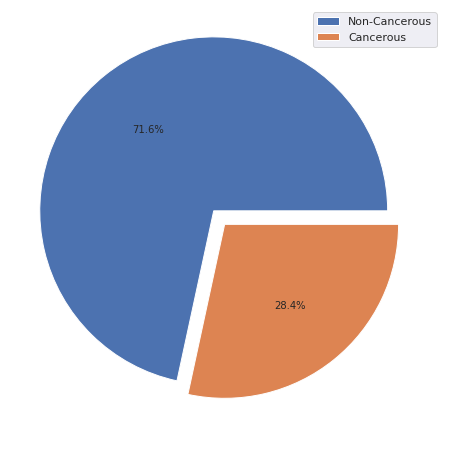

In [11]:
class0 = [] #no cancer
class1 = [] #cancer

for file in images: 
    if file.endswith('class0.png'): class0.append(file)
    else: class1.append(file)

print("Non-cancerous patches: ", len(class0))
print("Cancerous patches: ", len(class1))

labels = ('Non-Cancerous', 'Cancerous')
plt.figure(figsize = (8, 8))
plt.pie((len(class0), len(class1)), explode = (0.1, 0), autopct='%1.1f%%', )
plt.legend(labels, loc = 'upper right')
plt.show()

####Insights
* If we proceed with this size of class0 and class1, our model would be biased. 
* We randomly take len(class1) files from class0. 
* We will also randomize both sets as it may impose some pattern.

In [12]:
random.seed(10)
sample_class0 = random.sample(class0, len(class1))
print("Sample size of non-cancerous patches: ", len(sample_class0))
sample_class1 = random.sample(class1, len(class1))
print("Sample size of cancerous patches: ", len(sample_class1))

Sample size of non-cancerous patches:  78786
Sample size of cancerous patches:  78786


### Cancerous vs. Healthy Patches

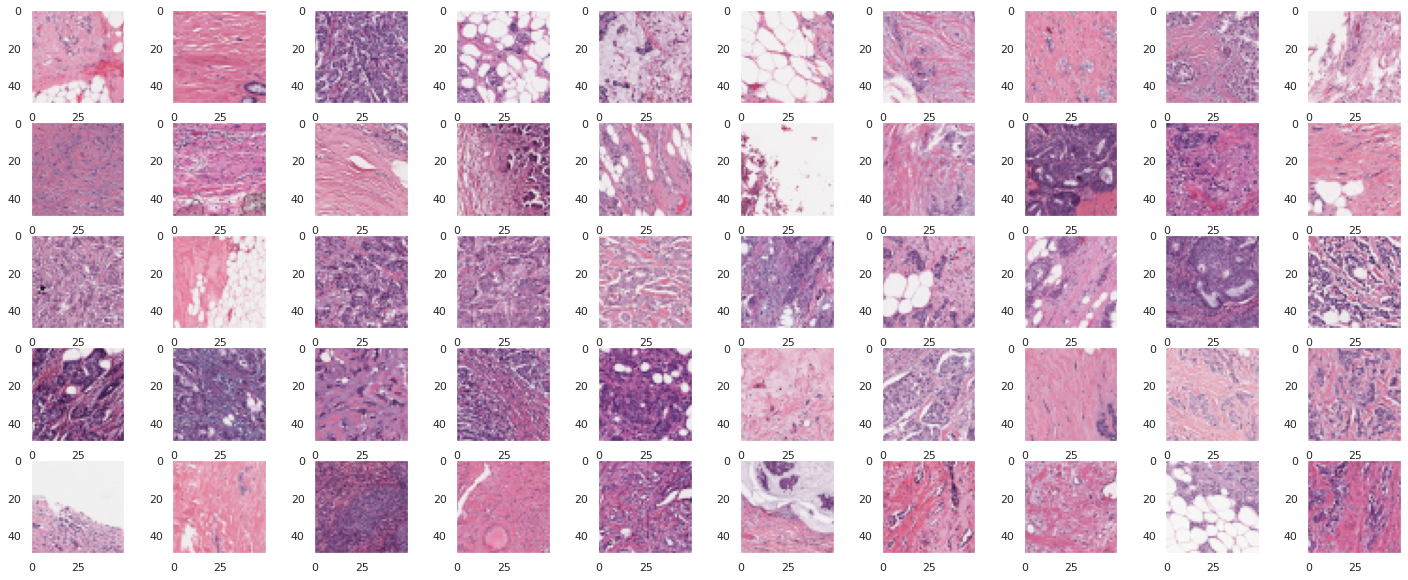

In [13]:
# Cancer
a = 0
fig, ax = plt.subplots(5,10,figsize=(25,10))

for n in range(5):
    for m in range(10):
        random.seed(a)
        a = a + 1
        image = imread(sample_class1[random.randint(0, len(sample_class1))])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

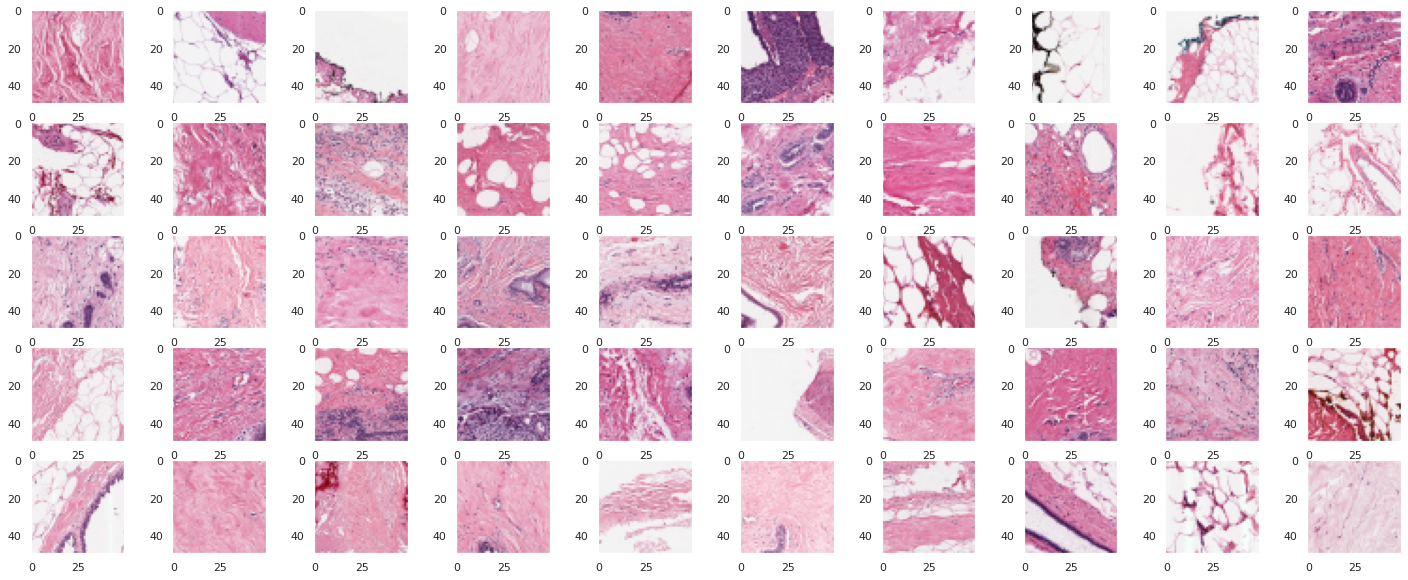

In [14]:
# Healthy
a = 55
fig, ax = plt.subplots(5,10,figsize=(25,10))

for n in range(5):
    for m in range(10):
        random.seed(a)
        a = a + 2
        image = imread(sample_class0[random.randint(0, len(sample_class0))])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

####Insights


* Patches with cancer look more violet and crowded than healthy ones.
* Some of the healthy patches are very violet colored too!
* I assume that the gaps in the tissue are mammary ducts where milk can flow through.   



### Data Pre-Processing


In [15]:
# Mix and Shuffle Dataset
# Divide by 50 due to system limitations 

random.seed(10)
data_mixed = random.sample(sample_class0, int(len(sample_class0) / 50)) + random.sample(sample_class1, int(len(sample_class1) / 50))
print('Total size of dataset: ',len(data_mixed))
random.shuffle(data_mixed)

Total size of dataset:  3150


In [16]:
data = []
labels = []

for i in tqdm(data_mixed):
    l = int(i[-5])
    img = im.img_to_array(im.load_img(i, target_size = (50,50)))
    data.append(img)
    labels.append(l)

# data[1]

  0%|          | 0/3150 [00:00<?, ?it/s]

In [17]:
# Set x and y
# Split into training and testing data
# Standardize data

y = np.array(labels)
x = np.array(data)/255 #Normalized the data or scaled image

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 19, test_size = 0.3)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
#print(x_train[1])

(2205, 50, 50, 3) (945, 50, 50, 3) (2205,) (945,)


## Models w/ Hyperparameter Tuning and Results

### Analysis Functions

#### ROC Curve 

In [18]:
def plot_roc_curve(roc_auc_train, roc_auc_test, fpr_ts_f, tpr_ts_f):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_tr, tpr_tr, 'g', label = 'Training AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_ts_f, tpr_ts_f, 'b', label = 'Testing AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### Confusion Matrix Plot

In [19]:
def plot_conf_matrix (conf_matrix, dtype):
    class_names = [0,1]
    fontsize=14
    df_conf_matrix = pd.DataFrame(
            conf_matrix, index=class_names, columns=class_names, 
        )
    fig = plt.figure()
    heatmap = sns.heatmap(df_conf_matrix, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for {0}'.format(dtype))

### Convolusional Neural Network (CNN)

#### CNN Model

In [20]:
# Build CNN Model
def build_cnn_model():
	model = Sequential()
	model.add(Conv2D(filters = 32, kernel_size = (4,4), input_shape = (50,50,3), activation = 'relu'))
	model.add(MaxPool2D(pool_size = (2,2)))
	model.add(MaxPool2D(pool_size = (2,2)))
	model.add(Dropout(0.25))
	model.add(Conv2D(filters = 32, kernel_size = (4,4), activation = 'relu'))
	model.add(MaxPool2D(pool_size = (2,2)))
	model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
	model.add(Dropout(0.25))
	model.add(Flatten())
	model.add(Dense(64, activation = 'relu'))
	model.add(Dense(1, activation = 'sigmoid'))
	model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
	return model

#### CNN Hyperparameter Tuning

In [21]:
# Create CNN Model Instance & Tune Hyperparameters w/ GridSearchCV
model_cnn = KerasClassifier(build_fn=build_cnn_model, verbose = 0)
batch_size = [10, 50, 100]
epochs = [10, 20, 30]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid_cnn = GridSearchCV(estimator=model_cnn, param_grid=param_grid, n_jobs=-1, scoring = 'roc_auc', cv = 3)
grid_result_cnn = grid_cnn.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result_cnn.best_score_, grid_result_cnn.best_params_))

Best: 0.867040 using {'batch_size': 10, 'epochs': 20}


#### CNN Results


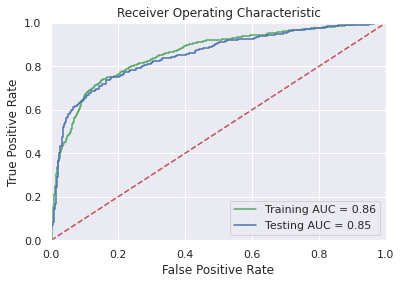

In [22]:
# CNN Predictions & ROC 
y_pred_train_cnn = grid_cnn.predict_proba(x_train)[:,1]
y_pred_test_cnn = grid_cnn.predict_proba(x_test)[:,1]

fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train_cnn)
roc_auc_train_cnn = auc(fpr_tr, tpr_tr)

fpr_ts_cnn, tpr_ts_cnn, threshold = roc_curve(y_test, y_pred_test_cnn)
roc_auc_test_cnn = auc(fpr_ts_cnn, tpr_ts_cnn)

plot_roc_curve(roc_auc_train_cnn, roc_auc_test_cnn, fpr_ts_cnn, tpr_ts_cnn)

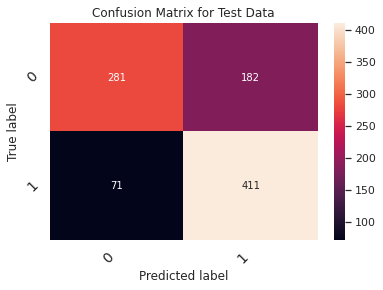

In [23]:
# CNN Confusion Matrix
plot_conf_matrix(confusion_matrix(y_test, grid_result_cnn.predict(x_test)), "Test Data")

### Recurrent Neural Network (RNN)

#### RNN Model

In [24]:
batch_size = 64
# Each image batch is a tensor of shape (batch_size, 50, 50).
# Each input sequence will be of size (50, 50) (height is treated like time).
input_dim = 50

units = 64
output_size = 2  # labels are from 0 to 1

In [25]:
# Build RNN model
def build_rnn_model():
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    lstm_layer = keras.layers.RNN(keras.layers.LSTMCell(units), input_shape=(None, input_dim))
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam")
    return model

In [26]:
x_rnn = np.zeros((x.shape[0], x.shape[1], x.shape[2]))

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        for k in range(x.shape[2]):
            x_rnn[i, j, k] = 0.11 * x[i, j, k, 0] + 0.59 * x[i, j, k, 1] + 0.3 * x[i, j, k, 2]

x_rnn_train, x_rnn_test, y_rnn_train, y_rnn_test = train_test_split(x_rnn, y, random_state=19, test_size=0.3)

#### RNN Hyperparameter Tuning

In [27]:
model_rnn = KerasClassifier(build_fn=build_rnn_model, verbose = 0)
batch_size = [10, 50, 100]
epochs = [10, 20, 30]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid_rnn = GridSearchCV(estimator=model_rnn, param_grid=param_grid, n_jobs=-1, scoring = 'roc_auc', cv = 3)
grid_result_rnn = grid_rnn.fit(x_rnn_train, y_rnn_train)
print("Best: %f using %s" % (grid_result_rnn.best_score_, grid_result_rnn.best_params_))

Best: 0.707283 using {'batch_size': 50, 'epochs': 20}


#### RNN Results

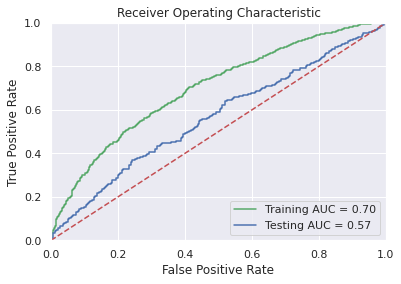

In [28]:
# RNN Predictions & ROC 
y_pred_train_rnn = grid_rnn.predict_proba(x_rnn_train)[:,1]
y_pred_test_rnn = grid_rnn.predict_proba(x_rnn_test)[:,1]

fpr_tr, tpr_tr, threshold = roc_curve(y_rnn_train, y_pred_train_rnn)
roc_auc_train_rnn = auc(fpr_tr, tpr_tr)

fpr_ts_rnn, tpr_ts_rnn, threshold = roc_curve(y_rnn_test, y_pred_test_rnn)
roc_auc_test_rnn = auc(fpr_ts_rnn, tpr_ts_rnn)

plot_roc_curve(roc_auc_train_rnn, roc_auc_test_rnn, fpr_ts_rnn, tpr_ts_rnn)

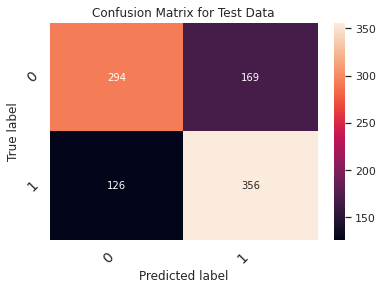

In [29]:
# RNN Confusion Matrix

plot_conf_matrix(confusion_matrix(y_rnn_test, grid_result_rnn.predict(x_rnn_test)), "Test Data")

### Artificial Neural Network (ANN)

#### ANN Model

In [30]:
x_train = x_train.reshape(-1, 7500)
x_test = x_test.reshape(-1, 7500)
print(x_train.shape, x_test.shape)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

(2205, 7500) (945, 7500)


In [31]:
def build_ann_model():
    model = Sequential()
    model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 7500))
    model.add(Dropout(0.5))
    model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    return model

#### ANN Hyperparamter Tuning

In [32]:
model_ann = KerasClassifier(build_fn = build_ann_model, verbose = 0)
batch_size = [10, 50, 100]
epochs = [10, 20, 30]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid_ann = GridSearchCV(estimator=model_ann, param_grid=param_grid, n_jobs=-1, scoring = 'roc_auc', cv = 3)
grid_result_ann = grid_ann.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result_ann.best_score_, grid_result_ann.best_params_))

Best: 0.837204 using {'batch_size': 100, 'epochs': 10}


#### ANN Results

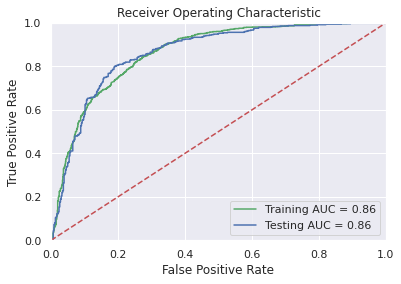

In [33]:
# ANN ROC Curve

y_pred_train_ann = grid_ann.predict_proba(x_train)[:,1]
y_pred_test_ann = grid_ann.predict_proba(x_test)[:,1]

fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train_ann)
roc_auc_train_ann = auc(fpr_tr, tpr_tr)

fpr_ts_ann, tpr_ts_ann, threshold = roc_curve(y_test, y_pred_test_ann)
roc_auc_test_ann = auc(fpr_ts_ann, tpr_ts_ann)

plot_roc_curve(roc_auc_train_ann, roc_auc_test_ann, fpr_ts_ann, tpr_ts_ann)

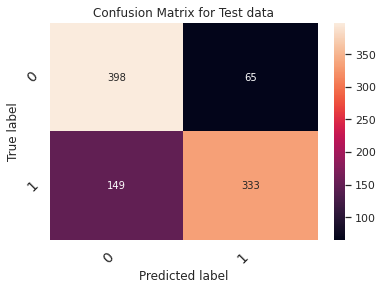

In [34]:
# ANN Confusion Matrix

plot_conf_matrix(confusion_matrix(y_test, grid_ann.predict(x_test)), "Test data")

## Model Comparison

[]

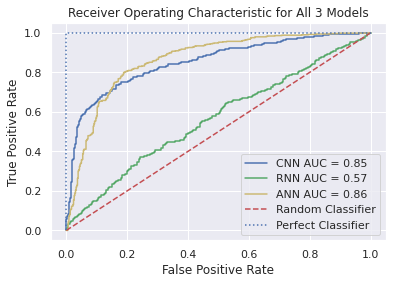

In [35]:
plt.plot(fpr_ts_cnn, tpr_ts_cnn, 'b', label = 'CNN AUC = %0.2f' % roc_auc_test_cnn)
plt.plot(fpr_ts_rnn, tpr_ts_rnn, 'g', label = 'RNN AUC = %0.2f' % roc_auc_test_rnn)
plt.plot(fpr_ts_ann, tpr_ts_ann, 'y', label = 'ANN AUC = %0.2f' % roc_auc_test_ann)
plt.plot([0, 1], [0, 1],'r--', label = 'Random Classifier')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label = 'Perfect Classifier')
plt.title('Receiver Operating Characteristic for All 3 Models')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot()

### Conclusion
The AUC for both CNN and ANN were found to be the best at ~0.86*, indicating that the models have similar performance. Also, the training and testing ROC curves for each model are similar, indicating that the models are well-fit (not over-fit). 

However, the ANN model requires significantly less run-time. As breast cancer diagnoses are time-sensitive, we recommend the ANN model. 

(*Values may vary slightly from run to run due to randomness)